# Assignment One - Analytics for Unstructured Data
#### Team Members: Haden Loveridge, Mikala Lowrance, Arantza Garcia Delfin, Neha R Boinapalli, Lindsay Bartol, Sameer Kahn, Biagio Alessandrello 

#### - 10 Brands we chose - Frequency Table

#### - Show all lift values in a table

#### - MDS Map

#### - State the 5 attributes you chose (again, a frequency table is good here) 

#### - For task F, provide all details of your analysis - e.g. how you measured "aspirational" and how you found the most aspirational brand.

#### - Advice/Insights based on your analysis for your client

#### --------------- Code ---------------

#### - Scraper

In [122]:
import csv
import requests
from bs4 import BeautifulSoup


def scrape_page(page_number):
    url = f"https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{page_number}"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id='vanilla_discussion_index')
    print(f"-- Scraping {url}")

    # GET ALL THE COMMENTS STARTING FROM THE LATEST
    forum_posts = results.find_all("div", class_="Comment")
    forum_posts.reverse()

    rows = []
    for post in forum_posts:
        post_date = post.find("span", class_="MItem DateCreated")
        post_comment = post.find("div", class_="Message userContent")

        # REMOVE QUOTED REPLIES, IF THEY EXIST
        if post_comment.find("blockquote"):
            post_comment.find("blockquote").decompose()

        row = [post_date.text.strip(), post_comment.text.strip()]
        rows.append(row)

    print(f"---- Got {len(rows)} comments")
    return rows


def scrape_pages(page_number=435, target_comment_count=5000):
    comments = []

    while len(comments) <= target_comment_count:
        print(f"- Total comments so far: {len(comments)}")
        page_data = scrape_page(page_number)
        comments.extend(page_data)
        page_number -= 1

    return comments


def print_csv(rows, filename='edmunds_comments'):
    with open(f'{filename}.csv', 'w', newline='') as file:
        writer = csv.writer(file)

        writer.writerow(["Date", "Comment"])
        writer.writerows(rows)


def run():
    data = scrape_pages()
    print_csv(data)


### - Task A

In [123]:
import csv
import re
import string
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
import io

#gets rid of word frequency definition
from collections import Counter

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [124]:
# Input and output filenames
input_filename = 'edmunds_comments.csv' # Input file
final_filename = 'A_mid.csv' # Intermediate file without the column header
word_freq_output = 'A_word_freq.csv' # Output file for word frequencies

In [125]:
# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    """
    Cleans a given sentence by removing punctuation and stopwords, converting text
    to lowercase,
    and tokenizing the remaining words.
    """
    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())
    # Tokenize and remove stopwords
    return sentence.split()

In [126]:
# Step 1: Remove header from the input CSV and create a new file without it
def remove_header(input_file, output_file):
    """
    Reads the input CSV file, removes the header, and writes the remaining rows
    into a new output file.
    """
    with open(input_file, mode='r', newline='', encoding='utf-8') as infile, \
         open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        next(infile) #skips the header
        outfile.writelines(infile)

In [127]:
#OUR SAMPLE FILE HAS THE COMMENTS IN THE SECOND COLUMN NOT THE THIRD

In [128]:
# Step 2: Extract and clean sentences from the text
def extract_sentences(file):
    """
    Extracts text data from the second column of the CSV file, splits it into
    sentences,
    and cleans each sentence by removing punctuation and stopwords.
    """

    sentences_clean = []

    with open(file, mode='r', newline='', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        
        # Iterate over rows in the CSV file
        for row in reader:
            # Assuming the text is in the third column (index 1)
            if len(row) > 1:
                text = row[1]
                
                # Split the text into sentences based on punctuation (.?!)
                sentences = re.split(r'[.!?]', text)
                
                # Clean and tokenize each sentence
                for sentence in sentences:
                    cleaned_tokens = clean_and_tokenize(sentence)
                    if cleaned_tokens:  # Avoid adding empty sentences
                        sentences_clean.extend(cleaned_tokens)
                        #sentences_clean.append(cleaned_tokens)
    return sentences_clean

In [129]:
# Step 4: Write word frequencies to CSV
def write_word_frequencies(word_freq, output_file):
    """
    Writes the word frequencies to the specified CSV file.
    """
    # Sort the word frequencies by frequency in descending order
    sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    
    with open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Word', 'Frequency'])  # Write header row

        for word, frequency in sorted_word_freq:
            writer.writerow([word, frequency])
    
    print(f"Word frequencies written to {output_file}")

In [130]:
# Main function to execute the workflow
def main():
    # Step 1: Remove header from the input CSV and create a new file without it
    remove_header(input_filename, final_filename)

    # Step 2: Extract and clean sentences from the text
    sentences_clean = extract_sentences(final_filename)

    # Step 3: Calculate word frequencies
    word_frequencies = Counter(sentences_clean)
    #calculate_word_frequencies(sentences_clean)

    # Step 4: Write word frequencies to CSV
    write_word_frequencies(word_frequencies, word_freq_output)

In [131]:
# Run the main function
if __name__ == "__main__":
    main()

Word frequencies written to A_word_freq.csv


##### Economic Testing

In [132]:
df = pd.read_csv('A_word_freq.csv')

df['Rank'] = df.index + 1

df['log_rank'] = np.log(df['Rank'])
df['log_freq'] = np.log(df['Frequency'])

df[:3]

,Word,Frequency,Rank,log_rank,log_freq
0,the,24148,1,0.000000,10.091957
1,a,11554,2,0.693147,9.354787
2,to,10087,3,1.098612,9.219003


In [133]:
X = sm.add_constant(df['log_rank'])

# Create the OLS model
model = sm.OLS(df['log_freq'], X)

# Fit the model
results = model.fit()

In [134]:
intercept = results.params['const']  # Intercept (the constant)
slope = results.params['log_rank']          # Slope (coefficient for x)

# Extract the R-squared value
r_squared = results.rsquared

# Extract the p-value for the slope
p_value = results.pvalues['log_rank']

conf_intervals = results.conf_int()

t_value = results.tvalues['log_rank']

In [135]:
# Print the results
print(f"Slope (Zipf's Law exponent s): {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")
print(f"P-value: {p_value}")
print(f"T-value: {t_value}")
print(f"Confidence Intervals:\n{conf_intervals}")

Slope (Zipf's Law exponent s): -1.3263764115616983
Intercept: 12.865069327902134
R-squared: 0.9734216959036043
P-value: 0.0
T-value: -888.0741567907027
Confidence Intervals:
                  0          1
const     12.838625  12.891513
log_rank  -1.329304  -1.323449


Next, we want to calculate the t-stat for the slope against the null hypothesis that the slope = -1, for python tests it against zero.
To do this, we subtract -1 from our estimated slope and then divide this by the standard error of the slope. This would be:
[(-1.326) - (-1)] / .001 = -326.4
This is a very large t-stat, and it shows that the null hypothesis is 326.4 standard errors from our estimated value. As a result, we can conclude that the slope is significantly different from -1.

Additionally, based on the 95% confidence interval of the coefficient of the regression of log_freq on log_rank, which was (-1,329304, -1.323449), Zipf's law is disproven as -1 is not included in the interval. This is further shown in how the p-value is smaller than 0.05 and the t-value has a huge magnitude, indicating the -1.326 coefficient is statistically significant and not by chance (further dispproving the null hypothesis).

##### Top 100 Graph

In [136]:
df_100 = df[:100].copy()

In [137]:
log_rank_end = df_100['log_rank'].iloc[99]  # log rank at rank 100
log_freq_end = df_100['log_freq'].iloc[99]
# Normalize all log frequencies by the log frequency at rank 100
df_100['norm_log_freq'] = df_100['log_freq'] - log_freq_end

In [138]:
X4 = sm.add_constant(df_100['log_rank'])

# Create the OLS model
model4 = sm.OLS(df_100['norm_log_freq'], X4)

# Fit the model
results4 = model4.fit()

intercept4 = results4.params['const']  # Intercept (the constant)
slope4 = results4.params['log_rank']  

print(f"Slope (Zipf's Law Slope s): {slope4}")
print(f"Intercept: {intercept4}")

Slope (Zipf's Law Slope s): -0.8596884698539108
Intercept: 4.017657422018116


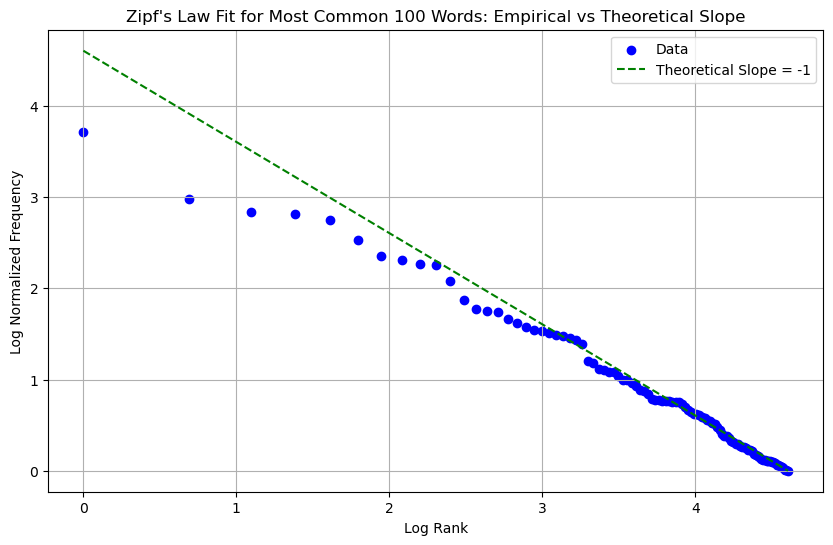

In [139]:
plt.figure(figsize=(10, 6))
plt.scatter(df_100['log_rank'], df_100['norm_log_freq'], label='Data', color='blue')

#plt.plot(df_100['log_rank'], intercept1 + slope1 * df_100['log_rank'], 'r', label='Fit: f(r) ∝ 1/r^s')


x_vals = df_100['log_rank']
y_vals = df_100['norm_log_freq'].iloc[-1] - (x_vals - log_rank_end)  # since slope is -1

plt.plot(x_vals, y_vals, 'g--', label=f'Theoretical Slope = -1')

plt.xlabel('Log Rank')
plt.ylabel('Log Normalized Frequency')
plt.title('Zipf\'s Law Fit for Most Common 100 Words: Empirical vs Theoretical Slope')
plt.legend()
plt.grid(True)
plt.show()

### - Task B

#### Word Frequencies (with car replacement, no stop words, by cell/text)

In [140]:
import csv
import re
import string
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
import io
import pandas as pd
import math
import numpy as np

In [141]:
#defining variables that might change when I switch from sample data to scraped data

data = 'edmunds_comments.csv'
text_row = 2 - 1
output_file = 'B_word_freq.csv'

In [142]:
#create a dictionary from the car brand and model csv

df = pd.read_csv('car_models_and_brands.csv')
model_to_brand = dict(zip(df['Model'], df['Brand']))

In [143]:
#function to clean and tokenize - here I'm taking out stop words and replacing model with brand as well

#Download and initialize stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_and_tokenize (sentence):
    #first we're going to remove punctuation
    no_punct = re.sub(f'[{re.escape(string.punctuation)}]', ' ', sentence)
    #now make lowercase
    lowered = no_punct.lower()
    #take out possessive punctuation
    for original, replacement in model_to_brand.items():
        lowered = re.sub(rf'\b{re.escape(original)}\'?s?\b', replacement, lowered, flags=re.IGNORECASE)
    #split the sentence into words
    words = lowered.split()
    #replace car models with brand names and remove stop words
    cleaned_words = []
    for word in words:
        if word in model_to_brand:
            cleaned_words.append(model_to_brand[word])  # Replace model with brand
        elif word not in stop_words:
            cleaned_words.append(word)  # Keep the word if it's not a stop word
    return cleaned_words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/biagio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
#Function to remove header, but I'm not actually using it

def remove_header(input, output):
    with open(input, 'r', newline = '') as header_file:
        reader = csv.reader(header_file)
        next(reader)
        #Now let's write the output file
        with open(output, 'w', newline='') as no_header_file:
            writer = csv.writer(no_header_file)
            for row in reader:
                writer.writerow(row)

In [145]:
#function to extract posts and clean them

def extract_text(file):

    text_clean = []
    with open(file, 'r', newline='', encoding='utf-8') as data_file:
        reader = csv.reader(data_file)
        # Skip the header
        next(reader)
        for row in reader:
            text = row[text_row]
            cleaned_tokens = clean_and_tokenize(text)
            if cleaned_tokens:  # Avoid adding empty sentences
                text_clean.append(cleaned_tokens)
    return text_clean

In [146]:
#Function to calculate word frequencies; counted once per post

def calculate_word_frequencies(text_list):
    frequencies = {}
    for text in text_list:
        unique_words = set(text)
        for word in unique_words:
            if word in frequencies:
                frequencies[word] += 1
            else:
                frequencies[word] = 1       
    return frequencies

In [147]:
#now write the frequencies to a csv

def write_word_frequencies(word_freq, output_file):
    with open(output_file, 'w', newline='', encoding='utf-8') as freq_file:
        writer = csv.writer(freq_file)
        #Write the header row
        writer.writerow(['Word', 'Frequency'])
        for word, freq in word_freq.items():
            writer.writerow([word, freq])        

In [148]:
def main():
    cleaned_text = extract_text(data)
    freq_dict = calculate_word_frequencies(cleaned_text)
    write_word_frequencies(freq_dict, output_file)

In [149]:
# Run the main function
if __name__ == "__main__":
    main()

##### Find Top Ten Brands

In [150]:
df = pd.read_csv(output_file)
df

,Word,Frequency
0,car,1933
1,updated,28
2,instead,78
3,eliminating,3
4,it’s,28
...,...,...
18248,outlay,1
18249,190k,1
18250,shelling,1
18251,174k,1


In [151]:
df = pd.read_csv(output_file)
df_brands = pd.read_csv('car_models_and_brands.csv')

#let's get just the brands so we can filter the words df
df_brands = df_brands[df_brands['Brand'] != 'car']
df_brands = df_brands[df_brands['Brand'] != 'seat']
df_brands = df_brands[df_brands['Brand'] != 'sedan']
df_brands = df_brands[df_brands['Brand'] != 'problem']
df_brands = df_brands['Brand'].unique()

#no filter for brand frequency
df_brand_freq = df[df['Word'].isin(df_brands)]
df_brand_freq = df_brand_freq.sort_values(by = 'Frequency', ascending = False)[:10].reset_index(drop = True)
df_brand_freq


,Word,Frequency
0,bmw,1018
1,audi,838
2,acura,529
3,honda,435
4,volkswagen,265
5,infiniti,241
6,toyota,213
7,cadillac,209
8,mercedes,202
9,hyundai,198


### - Task C

In [152]:
brand_list = list(df_brand_freq['Word'])
brand_list

['bmw',
 'audi',
 'acura',
 'honda',
 'volkswagen',
 'infiniti',
 'toyota',
 'cadillac',
 'mercedes',
 'hyundai']

In [153]:
import pandas as pd
import string
import re
import itertools

# Read the CSV file into a dataframe
df = pd.read_csv('edmunds_comments.csv')

# Load the car models and brands CSV into a dataframe
df_brands = pd.read_csv('car_models_and_brands.csv')

# Create a dictionary for faster lookup, where keys are the models and values are the brands
model_to_brand = dict(zip(df_brands['Model'], df_brands['Brand']))

df['Comment'] = df['Comment'].astype(str)

##########################################
######### PREPROCESSING FUNCTION #########
##########################################

def preprocess_Comment(Comment):
    if isinstance(Comment, str):  # Only process if Comment is a string
        Comment = Comment.lower()  # convert to lowercase
        Comment = Comment.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))  # replace punctuation with spaces
        Comment = ' '.join(Comment.split())  # remove extra spaces
    return Comment

# Apply preprocessing to the 'Comment' column
df['Comment'] = df['Comment'].apply(preprocess_Comment)

##########################################
######### REPLACE MODEL NAMES ###########
##########################################

# Function to replace model names in the 'Comment' column with their associated brands
# Ensures the model name is replaced only if it's a standalone word
def replace_model_with_brand(Comment):
    if isinstance(Comment, str):  # Only process if Comment is a string
        for model, brand in model_to_brand.items():
            # Use word boundaries (\b) to ensure the model name is not part of a longer word
            Comment = re.sub(r'\b{}\b'.format(re.escape(model.lower())), brand.lower(), Comment)
    return Comment

# Apply the function to the 'Comment' column after preprocessing
df['Comment'] = df['Comment'].apply(replace_model_with_brand)

In [154]:
##################################
######## CALCULATE LIFT ##########
##################################

brand_list = [brand.lower() for brand in brand_list]

def brand_mentioned(Comment, brand):
    # Use regular expressions to find whole words, ignoring punctuation
    return bool(re.search(rf'\b{re.escape(brand)}\b', Comment))

# Function to check if two brands are mentioned within 15 words of each other
def brands_within_15_words(Comment, brand1, brand2):
    words = Comment.split()
    brand1_indices = [i for i, word in enumerate(words) if word == brand1]
    brand2_indices = [i for i, word in enumerate(words) if word == brand2]
    for i in brand1_indices:
        for j in brand2_indices:
            if abs(i - j) <= 15:  # Check if brands are within 7 words
                return True
    return False

# Dictionary to store the lift values
lift_values = {}

# Calculate lift for each pair of brands
total_Comments = len(df)

for brand1, brand2 in itertools.combinations(brand_list, 2):
    # Count the number of Comments that mention brand1 and brand2 within 15 words of each other
    Comments_with_both = df['Comment'].apply(lambda Comment: brands_within_15_words(Comment, brand1, brand2)).sum()
    
    # Count the number of Comments that mention each brand (at least once)
    Comments_with_brand1 = df['Comment'].apply(lambda Comment: brand_mentioned(Comment, brand1)).sum()
    Comments_with_brand2 = df['Comment'].apply(lambda Comment: brand_mentioned(Comment, brand2)).sum()

    # print(f"Comments with {brand1}: {Comments_with_brand1}")
    # print(f"Comments with {brand2}: {Comments_with_brand2}")
    # print(f"Comments with {brand1} and {brand2}: {Comments_with_both}")
    # print()
    
    # Calculate the lift
    if Comments_with_brand1 > 0 and Comments_with_brand2 > 0:
        lift = (total_Comments * Comments_with_both) / (Comments_with_brand1 * Comments_with_brand2)
        lift_values[f'{brand1}-{brand2}'] = lift

In [155]:
# # Sort the dictionary by lift values (smallest to largest)
# sorted_lift_values = dict(sorted(lift_values.items(), key=lambda item: item[1]))

# # Print the sorted lift values
# for brand_pair, lift in sorted_lift_values.items():
#     print(f'{brand_pair}: {lift}')

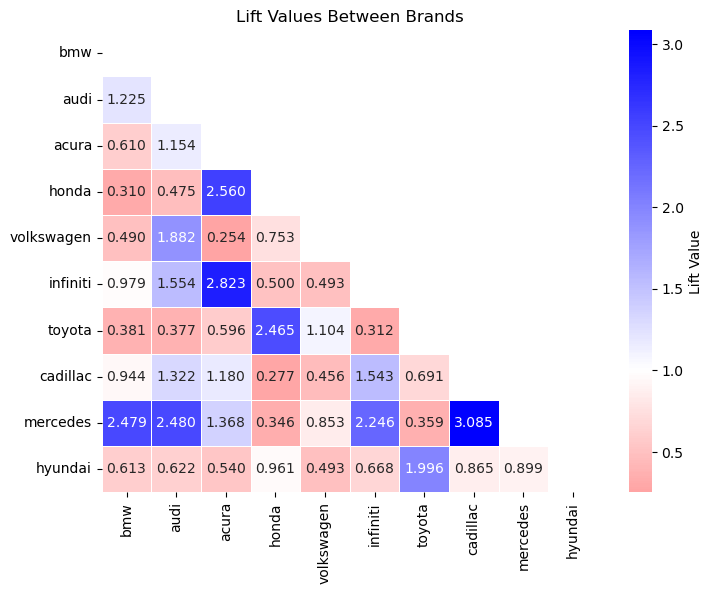

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create an empty DataFrame for the lift values, with brands as rows and columns
lift_df = pd.DataFrame(index=brand_list, columns=brand_list)

# Populate the DataFrame with lift values
for key, lift_value in lift_values.items():
    brand1, brand2 = key.split('-')  # Split the key into brand1 and brand2
    lift_df.loc[brand1, brand2] = lift_value
    lift_df.loc[brand2, brand1] = lift_value  # Since lift is symmetric

# Fill the diagonal with NaN or 0 since a brand compared to itself isn't meaningful
np.fill_diagonal(lift_df.values, np.nan)

# Convert to numeric type
lift_df = lift_df.astype(float)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(lift_df, dtype=bool))

# Define a custom colormap that shifts from red (<1) to blue (>1) with a gradient scale
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['red', 'white', 'blue'], N=256)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(lift_df, annot=True, fmt=".3f", cmap=cmap, linewidths=.5, mask=mask, cbar_kws={'label': 'Lift Value'}, center=1)
plt.title("Lift Values Between Brands")
plt.show()


### - Task D

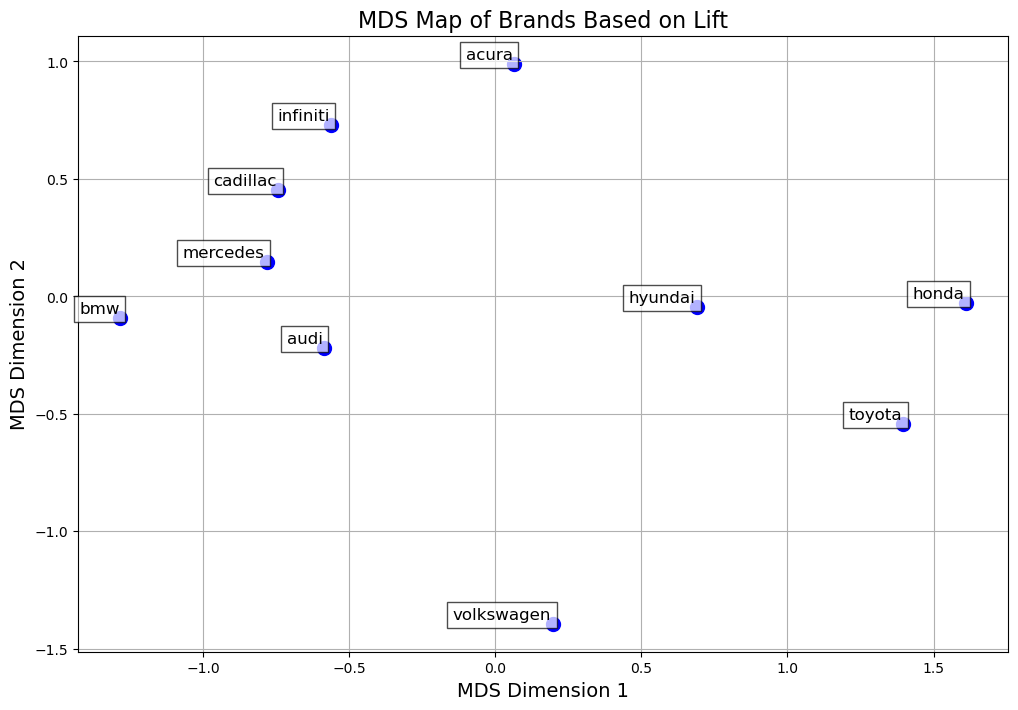

In [157]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text


distance_matrix = np.zeros((len(brand_list), len(brand_list)))

for i, brand1 in enumerate(brand_list):
    for j, brand2 in enumerate(brand_list):
        if i != j:
            # Get the lift value if it exists, otherwise use a default high distance (e.g., 1e6)
            lift_value = lift_values.get(f'{brand1}-{brand2}') or lift_values.get(f'{brand2}-{brand1}') or 1e6
            distance_matrix[i, j] = 1 / lift_value  # Inverse of lift as distance

# Apply Multi-Dimensional Scaling (MDS)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(distance_matrix)

# Plot the results
plt.figure(figsize=(12, 8))

# Scatter plot with markers for each brand
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], s=100, color='blue')

# List to store text objects for adjustment
texts = []

# Annotate points with brand names, and store text objects for adjustment
for i, brand in enumerate(brand_list):
    texts.append(plt.text(mds_coordinates[i, 0], mds_coordinates[i, 1], brand, fontsize=12, ha='right',
                          bbox=dict(facecolor='white', alpha=0.7)))

# Adjust the positions of the text labels to avoid overlap, add arrows pointing to the actual points
adjust_text(texts, x=mds_coordinates[:, 0], y=mds_coordinates[:, 1],
            arrowprops=dict(arrowstyle="->", color='gray', lw=1))

# Add title and axis labels
plt.title("MDS Map of Brands Based on Lift", fontsize=16)
plt.xlabel("MDS Dimension 1", fontsize=14)
plt.ylabel("MDS Dimension 2", fontsize=14)

# Add grid for better readability
plt.grid(True)

plt.show()

In [158]:
print(f"Stress: {mds.stress_}")


Stress: 13.214723470684827


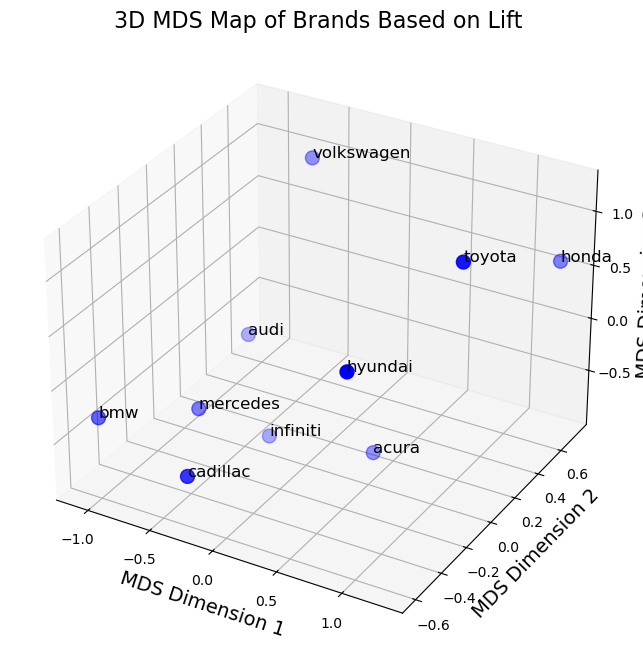

In [159]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plots

# Create the distance matrix
distance_matrix = np.zeros((len(brand_list), len(brand_list)))

for i, brand1 in enumerate(brand_list):
    for j, brand2 in enumerate(brand_list):
        if i != j:
            # Get the lift value if it exists, otherwise use a default high distance (e.g., 1e6)
            lift_value = lift_values.get(f'{brand1}-{brand2}') or lift_values.get(f'{brand2}-{brand1}') or 1e6
            distance_matrix[i, j] = 1 / lift_value  # Inverse of lift as distance

# Apply Multi-Dimensional Scaling (MDS) with 3 components
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(distance_matrix)

# Plot the results in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with markers for each brand in 3D
ax.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], mds_coordinates[:, 2], s=100, color='blue')

# Annotate points with brand names
for i, brand in enumerate(brand_list):
    ax.text(mds_coordinates[i, 0], mds_coordinates[i, 1], mds_coordinates[i, 2], brand, fontsize=12)

# Add title and axis labels
ax.set_title("3D MDS Map of Brands Based on Lift", fontsize=16)
ax.set_xlabel("MDS Dimension 1", fontsize=14)
ax.set_ylabel("MDS Dimension 2", fontsize=14)
ax.set_zlabel("MDS Dimension 3", fontsize=14)

# Show the plot
plt.show()


### - Task E

#### **What insights can you offer to your client from your analyses in Tasks C and D?**

From the key insights, we can identify three distinct customer profiles within the automotive market. These profiles can help shape targeted marketing strategies for better brand positioning:

**Jack of All Trades:**

Hyundai, Honda, and Toyota are tightly grouped due to their shared traits of affordability, reliability, and functionality. These Practical and Reliable customers are those who value having all the essentials, they prioritize dependability, affordability, and overall utility. They seek cars that meet all their essential needs without the burden of a high price tag, making these brands perfect for families or individuals looking for longevity and value. This customer segment would easily move between Honda and Toyota without hesitation, as both brands offer similar advantages in terms of practicality and dependability.

**Luxury Newbies:**

Acura and Infiniti serve as entry points into the luxury market. These brands appeal to younger professionals or buyers transitioning from more affordable brands into the luxury market. They seek comfort, modern technology, and a first taste of luxury without going all-in on high-end price tags. Customers in this segment may easily transition between Acura and Infiniti due to the similar value propositions and price points.

**Established Luxury Buyers:**

BMW, Mercedes, Cadillac, and Audi attract a more experienced luxury buyer, with higher disposable income. These customers prioritize premium features, status, and performance. BMW and Mercedes are frequently compared due to their similar level of luxury, brand history, and driving experience. Mercedes and Cadillac share a strong lift correlation, appealing to customers who value luxury interiors, high-end craftsmanship, and a sense of legacy. These brands may see customers moving between them as they compare features like comfort, performance, and prestige.

### - Task F

#### **What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS plot for this question.** 

Using the script we previously developed for word frequency analysis, we identified the most common attributes and their occurrence across all the comments. This allowed us to determine which key terms to prioritize for deeper analysis. Ultimately, we selected the following words for further investigation: performance, sport, engine, luxury, AWD, sedan, seat, power, and premium. The words and their frequencis in the comments shown in the table below.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Word</th>
      <th>Frequency</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>62</th>
      <td>luxury</td>
      <td>281</td>
    </tr>
    <tr>
      <th>89</th>
      <td>sedan</td>
      <td>264</td>
    </tr>
    <tr>
      <th>437</th>
      <td>awd</td>
      <td>273</td>
    </tr>
    <tr>
      <th>1099</th>
      <td>premium</td>
      <td>215</td>
    </tr>
    <tr>
      <th>1175</th>
      <td>seat</td>
      <td>271</td>
    </tr>
  </tbody>
</table>
</div>

After combining the words chosen above and the top car brands, we got the follwoing results below:

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Brand</th>
      <th>Lift Value</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>awd</th>
      <td>suzuki</td>
      <td>4.608974</td>
    </tr>
    <tr>
      <th>premium</th>
      <td>mercury</td>
      <td>1.950775</td>
    </tr>
    <tr>
      <th>luxury</th>
      <td>cadillac</td>
      <td>1.687793</td>
    </tr>
    <tr>
      <th>sedan</th>
      <td>hyundai</td>
      <td>1.370589</td>
    </tr>
    <tr>
      <th>seat</th>
      <td>dodge</td>
      <td>1.289719</td>
    </tr>
  </tbody>
</table>
</div>

The results reveal several interesting patterns in the comments. While sentiment analysis is needed to confirm whether these correlations are positive or negative, the findings align with expectations: BMW is strongly associated with “sport” and Cadillac with “luxury.” Notably, some unexpected combinations emerged, such as Subaru being linked with “performance,” Mercury with “premium,” and Suzuki with “AWD,” among others.

In [160]:
# Get the list of unique brands
unique_brands = df_brands['Brand'].unique()

# Convert to a Python list
unique_brands_list = unique_brands.tolist()

# Remove specific items one by one
for item in ['car', 'problem', 'seat', 'sedan']:
    if item in unique_brands_list:
        unique_brands_list.remove(item)

# Display the unique brands
unique_brands_list

['acura',
 'audi',
 'bmw',
 'buick',
 'cadillac',
 'chevrolet',
 'chrysler',
 'dodge',
 'ford',
 'honda',
 'hyundai',
 'infiniti',
 'kia',
 'lincoln',
 'mazda',
 'mercedes',
 'mercury',
 'mitsubishi',
 'nissan',
 'pontiac',
 'saturn',
 'subaru',
 'suzuki',
 'toyata',
 'toyota',
 'volkswagen',
 'volvo']

In [161]:
import pandas as pd
import re
import itertools

# List of top 5 most common attributes/features
attribute_list = ['performance', 'sport', 'engine', 'luxury', 'awd', 'sedan', 'seat', 'power', 'premium']

# Function to check if a brand or attribute is mentioned in the comment
def brand_mentioned(Comment, term):
    # Use regular expressions to find whole words, ignoring punctuation
    return bool(re.search(rf'\b{re.escape(term)}\b', Comment))

# Function to check if a brand and attribute are mentioned within 15 words of each other
def brands_within_15_words(Comment, brand, attribute):
    words = Comment.split()
    brand_indices = [i for i, word in enumerate(words) if word == brand]
    attribute_indices = [i for i, word in enumerate(words) if word == attribute]
    for i in brand_indices:
        for j in attribute_indices:
            if abs(i - j) <= 15:  # Check if they are within 15 words
                return True
    return False

# Dictionary to store the lift values
lift_values = {}

# Create a DataFrame to store the lift values with brands as rows and attributes as columns
lift_df = pd.DataFrame(index=unique_brands_list, columns=attribute_list)

# Calculate lift for each brand and attribute pair
total_Comments = len(df)

for brand in unique_brands_list:
    for attribute in attribute_list:
        # Count the number of Comments that mention both the brand and the attribute within 15 words of each other
        Comments_with_both = df['Comment'].apply(lambda Comment: brands_within_15_words(Comment, brand, attribute)).sum()

        # Count the number of Comments that mention the brand at least once
        Comments_with_brand = df['Comment'].apply(lambda Comment: brand_mentioned(Comment, brand)).sum()

        # Count the number of Comments that mention the attribute at least once
        Comments_with_attribute = df['Comment'].apply(lambda Comment: brand_mentioned(Comment, attribute)).sum()

        # Calculate the lift
        if Comments_with_brand > 0 and Comments_with_attribute > 0:
            lift = (total_Comments * Comments_with_both) / (Comments_with_brand * Comments_with_attribute)
            lift_df.loc[brand, attribute] = lift  # Store the lift value in the DataFrame
        else:
            lift_df.loc[brand, attribute] = None  # Set as None if no lift value can be calculated

# Display the lift table
lift_df


,performance,sport,engine,luxury,awd,sedan,seat,power,premium
acura,0.663634,0.509138,0.763798,1.07405,1.536325,0.827323,0.42209,0.390664,0.975388
audi,0.649311,0.966996,0.69632,0.701224,1.038953,0.683182,0.846204,0.643049,1.178886
bmw,0.643365,1.221263,0.667507,0.628558,0.454086,0.767183,0.7319,0.5487,0.576584
buick,0.0,0.196509,0.0,1.16591,0.727733,0.999603,0.488736,0.271409,0.616034
cadillac,0.455063,0.142235,0.153632,1.687793,0.17558,0.633082,0.088438,0.0,1.226202
chevrolet,0.267684,0.376505,0.271116,0.595692,0.309847,0.1596,0.468201,0.0,0.983584
chrysler,0.0,0.426706,0.0,0.506338,0.26337,0.0,0.265314,1.178689,0.668837
dodge,0.442423,0.207427,0.224047,0.73841,0.0,0.263784,1.289719,0.286487,1.625646
ford,0.76298,0.089429,0.193191,0.424475,0.772762,0.341182,0.667256,0.741092,0.841053
honda,0.368686,0.587709,0.709483,0.615341,0.725487,0.791352,0.472897,0.334235,0.59607


In [162]:
# Find the brand with the highest lift value for each attribute
highest_lift_per_attribute = lift_df.idxmax()

# Find the maximum lift value for each attribute
max_lift_values = lift_df.max()

# Combine the two into a DataFrame
highest_lift_summary = pd.DataFrame({
    'Brand': highest_lift_per_attribute,
    'Lift Value': max_lift_values
})

# Filter out the low lift words (Performance, engine, sedan, seat)
# List of attributes to filter out
words_to_exclude = ['performance', 'engine', 'sedan', 'seat']

# Filter out the specified words from the highest_lift_summary
filtered_highest_lift_summary = highest_lift_summary.drop(index=words_to_exclude, errors='ignore')

# Display the result
filtered_highest_lift_summary


,Brand,Lift Value
sport,bmw,1.221263
luxury,cadillac,1.687793
awd,suzuki,4.608974
power,chrysler,1.178689
premium,mercury,1.950775


In [163]:
df

,Date,Comment
0,May 2021,it’s a nice car they should have updated inste...
1,May 2021,explorerx4 how do you like your lincoln lincol...
2,July 2020,yes i d like to see acura bring back a hatchba...
3,July 2020,if they won t bring back acura the acura is a ...
4,July 2020,there s speculation that the acura name might ...
...,...,...
5028,February 2014,heresy if repeated over on chronic car buyers ...
5029,February 2014,nyccarguy exactly you have to evaluate all you...
5030,February 2014,stickguy even with the coil packs you had to r...
5031,February 2014,now that i have inherited my acura tl back a 2...


In [164]:
df2 = pd.read_csv(output_file)
words_of_interest = ['awd', 'premium', 'luxury', 'sedan', 'seat']
# Filter the dataframe to include only the words in `words_of_interest`
filtered_word_frequencies_df = df2[df2['Word'].isin(words_of_interest)]
# Display the filtered dataframe
filtered_word_frequencies_df

,Word,Frequency
72,luxury,281
91,sedan,264
446,awd,273
1109,premium,215
1176,seat,271


In [165]:
df_brands = pd.read_csv('car_models_and_brands.csv')

#let's get just the brands so we can filter the words df
df_brands = df_brands[df_brands['Brand'] != 'car']
df_brands = df_brands[df_brands['Brand'] != 'seat']
df_brands = df_brands[df_brands['Brand'] != 'sedan']
df_brands = df_brands[df_brands['Brand'] != 'problem']
df_brands = df_brands['Brand'].unique()

#no filter for brand frequency
df_brand_freq = df2[df2['Word'].isin(df_brands)]
df_brand_freq = df_brand_freq.sort_values(by = 'Frequency', ascending = False)[:10].reset_index(drop = True)
df_brand_freq


,Word,Frequency
0,bmw,1018
1,audi,838
2,acura,529
3,honda,435
4,volkswagen,265
5,infiniti,241
6,toyota,213
7,cadillac,209
8,mercedes,202
9,hyundai,198


### - Task G

1. AWD and Suzuki (Lift Value: 4.6)
The highest lift value of 4.6 is seen between AWD (all-wheel drive) and Suzuki. While sentiment analysis is required to confirm whether this association is positive, if it is, Suzuki can confidently target off-road driving enthusiasts in their marketing campaigns, highlighting their strength in the AWD segment.
2. Sport and BMW (Lift Value: 1.2)
The lift value between "sport" and BMW is 1.2, suggesting a moderate positive association. If BMW wants to maintain its status as a premier luxury sports brand, it should strengthen its marketing efforts toward sporty vehicle enthusiasts. Although 1.2 indicates a positive link, BMW should aim for a higher association, especially given its reputation.
3. Luxury and Cadillac (Lift Value: 1.7)
A lift value of 1.7 between "luxury" and Cadillac is a strong indicator that Cadillac’s vehicles are resonating with luxury car buyers. This positive association could be capitalized on by promoting iconic models like the Escalade, which is frequently used in luxury transport.
4. Sedan and Hyundai (Lift Value: 1.4)
Hyundai’s association with sedans, reflected by a lift value of 1.4, shows a positive link. Hyundai should focus on further enhancing its sedan models, ensuring high satisfaction among sedan buyers, as this segment is clearly a key driver for the brand.
5. Premium and Mercury (Lift Value: 1.95)
Interestingly, there is a 1.95 lift between "premium" and Mercury, despite the brand being discontinued 13 years ago. This strong positive association shows that Mercury vehicles are still highly regarded by their owners, suggesting that Ford did an excellent job with the brand’s quality and appeal, which continues to be appreciated.
6. Performance and Subaru (Lift Value: 0.98)
The lift value for "performance" and Subaru is just below 1.0 at 0.98, indicating a near-neutral association. To strengthen its positioning in the performance segment, Subaru should focus on targeting performance-oriented drivers, leveraging its loyal customer base to expand its appeal in this category.
7. Power and Chrysler (Lift Value: 1.18)
With a lift value of 1.18 between "power" and Chrysler, there is a moderate positive association. Chrysler can leverage this by focusing its messaging on the power and performance aspects of its vehicles. Highlighting powertrain capabilities and powerful driving experiences could help Chrysler further solidify its position in this segment and attract more performance-conscious buyers.


### - Task H

In [166]:
df

,Date,Comment
0,May 2021,it’s a nice car they should have updated inste...
1,May 2021,explorerx4 how do you like your lincoln lincol...
2,July 2020,yes i d like to see acura bring back a hatchba...
3,July 2020,if they won t bring back acura the acura is a ...
4,July 2020,there s speculation that the acura name might ...
...,...,...
5028,February 2014,heresy if repeated over on chronic car buyers ...
5029,February 2014,nyccarguy exactly you have to evaluate all you...
5030,February 2014,stickguy even with the coil packs you had to r...
5031,February 2014,now that i have inherited my acura tl back a 2...


In [167]:
# List of words you want in the dataframe
#aspirational_words_list = ['hope', 'wish', 'prestige', 'future', 'dream', 'exclusive', 'ultimate', 'success', 'refinement']
aspirational_words_list = [
    'hope', 'wish', 'prestige', 'future', 'dream', 'exclusive', 'ultimate', 'success', 'refinement',
    'luxury', 'elite', 'opulence', 'visionary', 'ambition', 'inspiration', 'excellence', 'innovation',
    'empowerment', 'sophistication', 'mastery', 'perfection', 'status', 'timeless', 'iconic', 
    'distinctive', 'aspire', 'achievement', 'leadership', 'prosperity', 'growth', 'elegance', 
    'grandeur', 'supreme', 'triumph', 'transformation'
]


# Create the dataframe with an additional column 'Category' filled with 'aspirational'
aspirational_words_df = pd.DataFrame({
    'Aspirational': ['aspirational'] * len(aspirational_words_list), 
    'Word': aspirational_words_list  # First column for words
})

# Display the new dataframe
aspirational_words_df


,Aspirational,Word
0,aspirational,hope
1,aspirational,wish
2,aspirational,prestige
3,aspirational,future
4,aspirational,dream
5,aspirational,exclusive
6,aspirational,ultimate
7,aspirational,success
8,aspirational,refinement
9,aspirational,luxury


In [168]:
import re
import pandas as pd
#df = pd.read_csv('edmunds_comments.csv')

# Function to replace words in the 'Comment' column with 'aspirational'
def replace_words_with_aspirational(comment):
    if isinstance(comment, str):  # Only process if the comment is a string
        for word in aspirational_words_df['Word']:
            # Replace each word from the aspirational_words_df with 'aspirational'
            comment = re.sub(r'\b{}\b'.format(re.escape(word.lower())), 'aspirational', comment.lower())
    return comment

# Apply the function to the 'Comment' column in df_comments
df['Comment'] = df['Comment'].apply(replace_words_with_aspirational)
df['Comment'].fillna('').astype(str)

# Display the updated comments
df.head()


,Date,Comment
0,May 2021,it’s a nice car they should have updated inste...
1,May 2021,explorerx4 how do you like your lincoln lincol...
2,July 2020,yes i d like to see acura bring back a hatchba...
3,July 2020,if they won t bring back acura the acura is a ...
4,July 2020,there s speculation that the acura name might ...


In [120]:
import pandas as pd
import re
import itertools

# List of top 5 most common attributes/features
attribute_list = ['aspirational']

# Function to check if a brand or attribute is mentioned in the comment
def brand_mentioned(Comment, term):
    # Use regular expressions to find whole words, ignoring punctuation
    return bool(re.search(rf'\b{re.escape(term)}\b', Comment))

# Function to check if a brand and attribute are mentioned within 15 words of each other
def brands_within_15_words(Comment, brand, attribute):
    words = Comment.split()
    brand_indices = [i for i, word in enumerate(words) if word == brand]
    attribute_indices = [i for i, word in enumerate(words) if word == attribute]
    for i in brand_indices:
        for j in attribute_indices:
            if abs(i - j) <= 15:  # Check if they are within 15 words
                return True
    return False

# Dictionary to store the lift values
lift_values = {}

# Create a DataFrame to store the lift values with brands as rows and attributes as columns
lift_df = pd.DataFrame(index=unique_brands_list, columns=attribute_list)

# Calculate lift for each brand and attribute pair
total_Comments = len(df)

for brand in unique_brands_list:
    for attribute in attribute_list:
        # Count the number of Comments that mention both the brand and the attribute within 15 words of each other
        Comments_with_both = df['Comment'].apply(lambda Comment: brands_within_15_words(Comment, brand, attribute)).sum()

        # Count the number of Comments that mention the brand at least once
        Comments_with_brand = df['Comment'].apply(lambda Comment: brand_mentioned(Comment, brand)).sum()

        # Count the number of Comments that mention the attribute at least once
        Comments_with_attribute = df['Comment'].apply(lambda Comment: brand_mentioned(Comment, attribute)).sum()

        # Calculate the lift
        if Comments_with_brand > 0 and Comments_with_attribute > 0:
            lift = (total_Comments * Comments_with_both) / (Comments_with_brand * Comments_with_attribute)
            lift_df.loc[brand, attribute] = lift  # Store the lift value in the DataFrame
        else:
            lift_df.loc[brand, attribute] = None  # Set as None if no lift value can be calculated

# Display the lift table
lift_df

,aspirational
acura,0.881402
audi,0.76468
bmw,0.713226
buick,1.02057
cadillac,1.436358
chevrolet,0.796636
chrysler,0.492466
dodge,0.718179
ford,0.516057
honda,0.618432
